# Hystersis Loop Dataset - AFM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/DTMicroscope/blob/main/notebooks/Static%20Problems/LoopFittingProblem.ipynb)
 This dataset is a 50x50 hysteresis loop dataset on a PbTiO3 thin film, acquired by piezoresponse force spectroscopy. You can use this to test different fitting algorithms. The X,Y scale on the images is 2um

by R. Vasudevan (CNMS/ORNL)


In [33]:
import matplotlib.pyplot as plt
import numpy as np

In [41]:
!wget "https://www.dropbox.com/scl/fi/ivmxmev4jbu8cuvwhmsyd/hysteresis_loops.zip?rlkey=d51xjygdabt4xorix9ebcmpdq&dl=1" -O hysteresis_loops.zip
!unzip hysteresis_loops.zip

hysteresis_loops = np.load('hysteresis_loops.npy')
dc_vec = np.load('dc_vec.npy')

--2025-12-16 22:24:39--  https://www.dropbox.com/scl/fi/ivmxmev4jbu8cuvwhmsyd/hysteresis_loops.zip?rlkey=d51xjygdabt4xorix9ebcmpdq&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbff6e3aa6fa5aeaca99bd4ce8b.dl.dropboxusercontent.com/cd/0/inline/C3IhnPreaOs-NwR6qUBHMNsw24FUyQfVNPIvNEoksv1WMnSxfnkaEBfHJFyqJ4Ik8JW_ebH91wIIy7ihNVRhOC0L1rjhpcPSx_SB07gZPVxDdM9jIdrMg8M35ylWFbdoz2MdCCJ4y9WM114nTnQltkI-/file?dl=1# [following]
--2025-12-16 22:24:40--  https://ucbff6e3aa6fa5aeaca99bd4ce8b.dl.dropboxusercontent.com/cd/0/inline/C3IhnPreaOs-NwR6qUBHMNsw24FUyQfVNPIvNEoksv1WMnSxfnkaEBfHJFyqJ4Ik8JW_ebH91wIIy7ihNVRhOC0L1rjhpcPSx_SB07gZPVxDdM9jIdrMg8M35ylWFbdoz2MdCCJ4y9WM114nTnQltkI-/file?dl=1
Resolving ucbff6e3aa6fa5aeaca99bd4ce8b.dl.dropboxusercontent.com (ucbff6e3aa6fa5aeaca99bd4ce8b.dl.dropboxusercontent.com).

# Plot some random loops

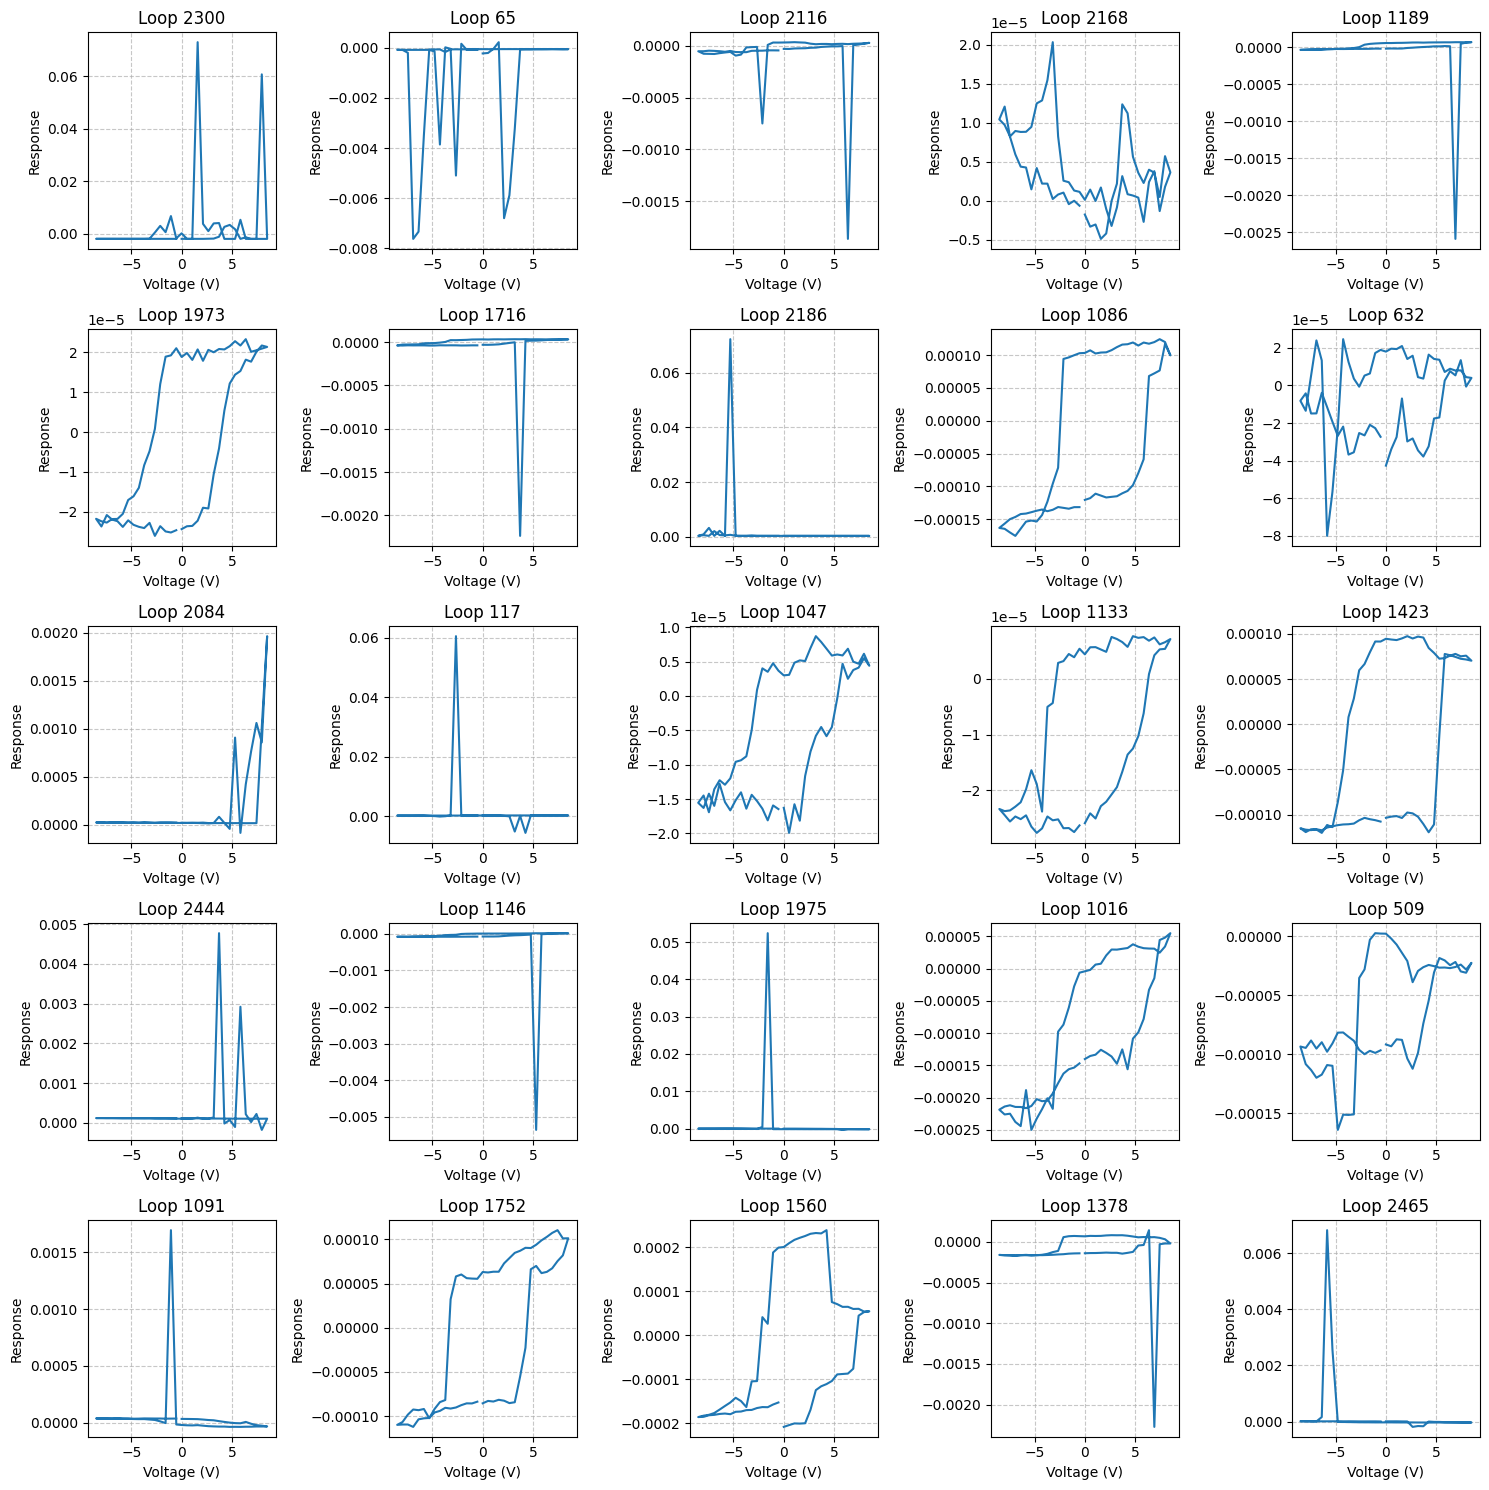

In [42]:

if hysteresis_loops.ndim == 3:
    loops_flat = hysteresis_loops.reshape(-1, hysteresis_loops.shape[-1])
else:
    loops_flat = hysteresis_loops

num_loops_to_plot = 25
# Randomly select 25 indices for the hysteresis loops to plot
random_indices = np.random.choice(loops_flat.shape[0], num_loops_to_plot, replace=False)

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten() # Flatten the 5x5 array of axes for easier iteration

# Plot each random hysteresis loop in a separate subplot
for i, ax in enumerate(axes):
    loop_index = random_indices[i]
    loop_data = loops_flat[loop_index]

    ax.plot(dc_vec, loop_data)
    ax.set_title(f'Loop {loop_index}')
    ax.set_xlabel('Voltage (V)')
    ax.set_ylabel('Response')
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

In [40]:
# The loop fit function is defined in the cell below.
#This is the fit function for the loop - be careful with the DC vector!

## The loop fit function is defined in the cell below.
## This is the fit function for the loop - be careful with the DC vector!

In [43]:
def loop_fit_function(vdc, coef_vec):
    """
    9 parameter fit function

    Parameters
    -----------
    vdc : 1D numpy array or list
        DC voltages
    coef_vec : 1D numpy array or list
        9 parameter coefficient vector

    Returns
    ---------
    loop_eval : 1D numpy array
        Loop values
    """

    a = coef_vec[:5]
    b = coef_vec[5:]
    d = 1000

    v1 = np.asarray(vdc[:int(len(vdc) / 2)])
    v2 = np.asarray(vdc[int(len(vdc) / 2):])

    g1 = (b[1] - b[0]) / 2 * (erf((v1 - a[2]) * d) + 1) + b[0]
    g2 = (b[3] - b[2]) / 2 * (erf((v2 - a[3]) * d) + 1) + b[2]

    y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
    y2 = (g2 * erf((v2 - a[3]) / g2) + b[2]) / (b[2] + b[3])

    f1 = a[0] + a[1] * y1 + a[4] * v1
    f2 = a[0] + a[1] * y2 + a[4] * v2

    loop_eval = np.hstack((f1, f2))
    return loop_eval

#Using this loop fit function, fit the projected loop (the third panel in the previous figure).
#You will need to be careful about the way the x vector is passed it needs to be 'rolled'
#I.e., Vdc needs to be increasing on one branch and decreasing on another, and split in the middle.